In [127]:
import sys
import os 
import numpy as np
import gc
import cv2
import tensorflow as tf
import tensorflow.keras as keras 
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import imageio
import time
import shutil

from PIL import Image
from tqdm.notebook import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split

In [128]:
ROOT_DIR = globals()['_dh'][0]
PROJECT_DIR = ROOT_DIR.parent
DATA_DIR = PROJECT_DIR / "data"
TRAIN_DIR = DATA_DIR / "train_v2"
MEDIA_DIR = PROJECT_DIR / "media"
PROCESSED_CSV_NAME = "files_data.csv"

IMG_WIDTH = 768
IMG_HEIGHT = 768
N_CHANNELS = 3
IMG_SIZE = [IMG_HEIGHT, IMG_WIDTH, N_CHANNELS]

gc.enable()
sys.path.append(str(PROJECT_DIR))

In [129]:
from utils import *

In [130]:
if not os.path.exists(MEDIA_DIR):
    os.makedirs(MEDIA_DIR)

# EDA

In [131]:
df = pd.read_csv(DATA_DIR / "train_ship_segmentations_v2.csv")
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [132]:
df.shape

(231723, 2)

In [133]:
all_files = os.listdir(DATA_DIR / "train_v2")
df["ImageId"].unique().shape[0] == len(all_files)

True

In [134]:
print(len(all_files), df["ImageId"].unique().shape[0])

192556 192556


In [135]:
not_empty = df[~df.EncodedPixels.isnull()]
not_empty.shape

(81723, 2)

In [136]:
df['not_empty'] = df.EncodedPixels.map(lambda rle: True if isinstance(rle, str) else False)

In [137]:
files_data = df.groupby('ImageId').agg({'not_empty': 'sum'}).reset_index().rename(columns={'not_empty': 'ships'})

In [138]:
files_data

,ImageId,ships
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,5
4,0001b1832.jpg,0
...,...,...
192551,fffedbb6b.jpg,0
192552,ffff2aa57.jpg,0
192553,ffff6e525.jpg,0
192554,ffffc50b4.jpg,0


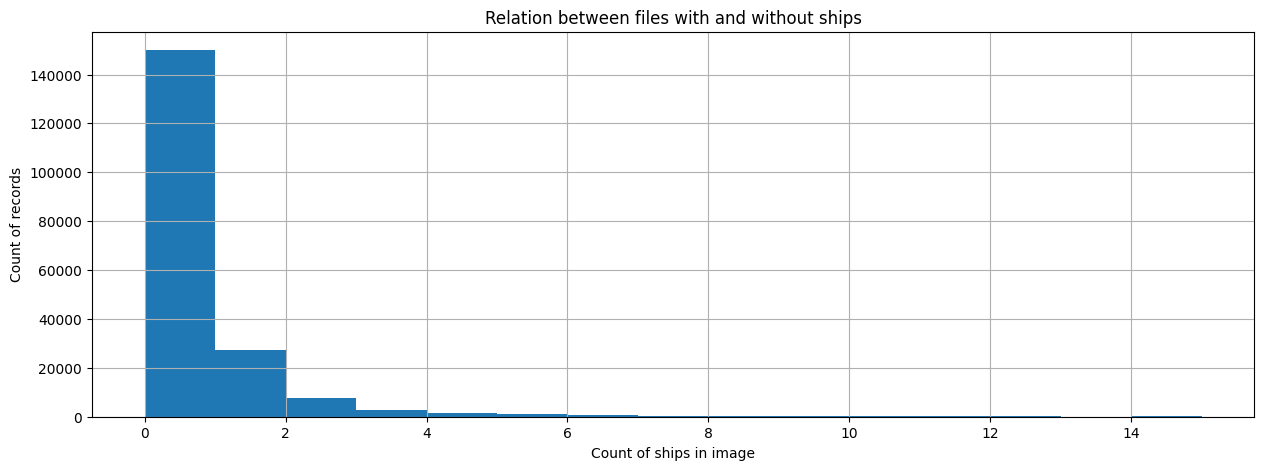

In [139]:
plt.figure(figsize=(15, 5))
files_data['ships'].hist(bins=files_data['ships'].max()) 
plt.ylabel('Count of records')
plt.xlabel('Count of ships in image')
plt.title('Relation between files with and without ships')
plt.show()

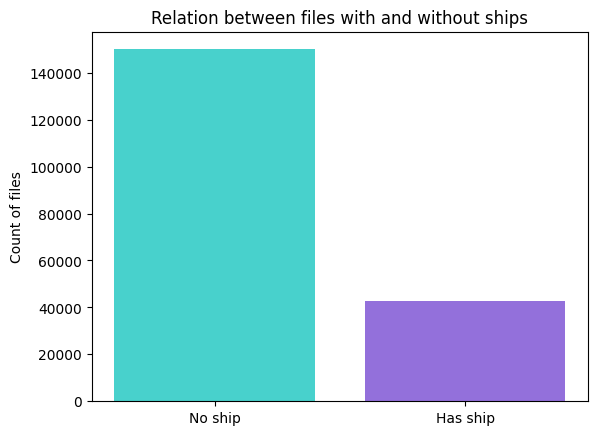

In [140]:
has_ship_hist_y = (files_data['ships'] > 0).value_counts()
has_ship_hist_x = ["No ship", "Has ship"]
plt.bar(has_ship_hist_x, has_ship_hist_y, color=['mediumturquoise', 'mediumpurple'])
plt.ylabel('Count of files')
plt.title('Relation between files with and without ships')
plt.show()

In [141]:
has_ship_hist_y[0] / has_ship_hist_y[1]

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\3890122535.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  has_ship_hist_y[0] / has_ship_hist_y[1]


3.5247673653538865

The number of images without ships is 3.5 times greater than the number of images with ships.

Let's check the distribution of ship areas.

In [142]:
# %%time

# ship_areas_ = not_empty.EncodedPixels.apply(lambda x: np.sum(rle_decode(x)))

# CPU times: total: 35 s
# Wall time: 35 s

In [143]:
ship_areas = not_empty.EncodedPixels.apply(lambda x: np.sum([int(s) for s in x.split()[1::2]]))

# CPU times: total: 1.31 s
# Wall time: 1.31 s

In [144]:
# (ship_areas_ - ship_areas).sum() # 0

In [145]:
ship_areas_min = ship_areas.min()
ship_areas_max = ship_areas.max()
ship_areas_mean = ship_areas.mean()
ship_areas_std = ship_areas.std()
ship_areas_median = ship_areas.median()
ship_areas_90th = ship_areas.quantile(0.90)

print(f"Ship areas min: {ship_areas_min}")
print(f"Ship areas max: {ship_areas_max}")
print(f"Ship areas mean: {ship_areas_mean}")
print(f"Ship areas std: {ship_areas_std}")
print(f"Ship areas median: {ship_areas_median}")
print(f"Ship areas 90th percentile: {ship_areas_90th}")

Ship areas min: 2
Ship areas max: 25904
Ship areas mean: 1567.4028486472596
Ship areas std: 2842.08120314158
Ship areas median: 408.0
Ship areas 90th percentile: 4872.0


<Axes: >

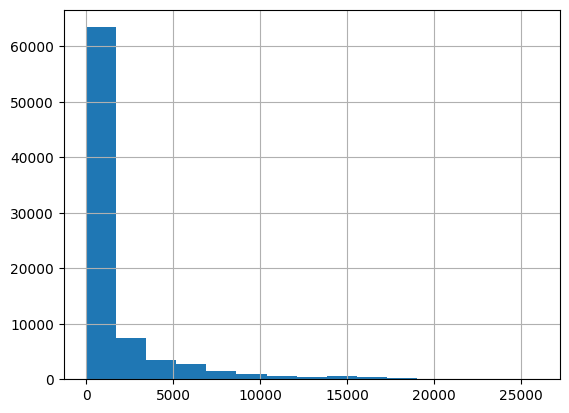

In [146]:
ship_areas.hist(bins=15)

<Axes: >

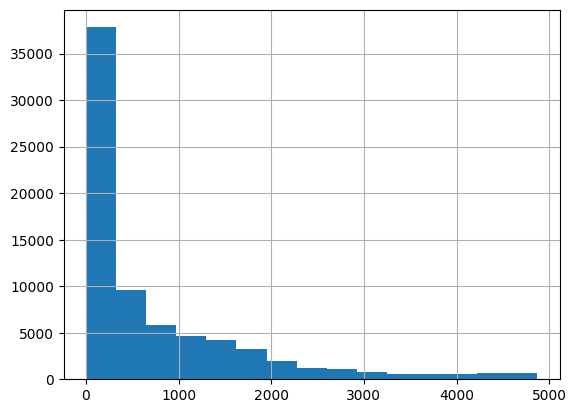

In [147]:
ship_areas[ship_areas < ship_areas_90th].hist(bins=15)

As we can see, there are significantly more small ships than large ones.

If our task were to address competition rather than simply build a UNet model, it would be possible to try constructing separate segmentators for small and large ships and then combine them.

In [148]:
not_empty = pd.concat([not_empty, pd.Series(ship_areas, name="ship_size")], axis=1)
not_empty.sample(5)

,ImageId,EncodedPixels,ship_size
139073,998001893.jpg,250780 2 251547 5 252315 7 253082 10 253850 12...,130
44527,3187bddf0.jpg,365004 2 365769 5 366534 9 367299 12 368064 15...,1857
82686,5b5988128.jpg,226974 2 227740 4 228508 4 229276 5 230045 4 2...,40
178237,c4f092962.jpg,368950 3 369718 3 370483 6 371246 12 372009 17...,165
184739,cc207f751.jpg,156655 3 157423 8 158191 13 158958 17 159726 1...,1366


Let's check the quality of the images.

In [149]:
files_data['file_size_kb'] = files_data.ImageId.map(lambda fname: os.stat(TRAIN_DIR / fname).st_size / 1024)

<Axes: >

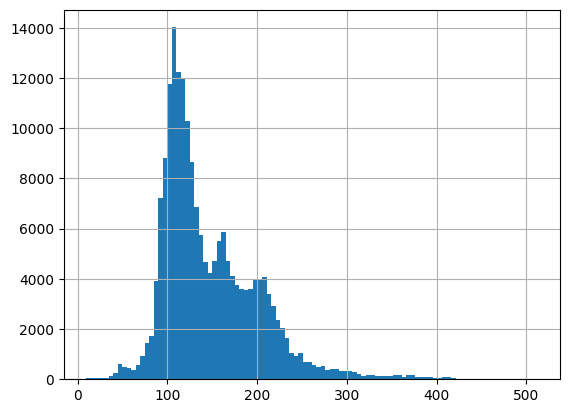

In [150]:
files_data["file_size_kb"].hist(bins=100)

In [151]:
files_data["file_size_kb"].describe()

count    192556.000000
mean        147.174686
std          54.292004
min           9.612305
25%         108.333496
50%         130.307617
75%         177.967529
max         511.942383
Name: file_size_kb, dtype: float64

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\1884615198.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / fname)


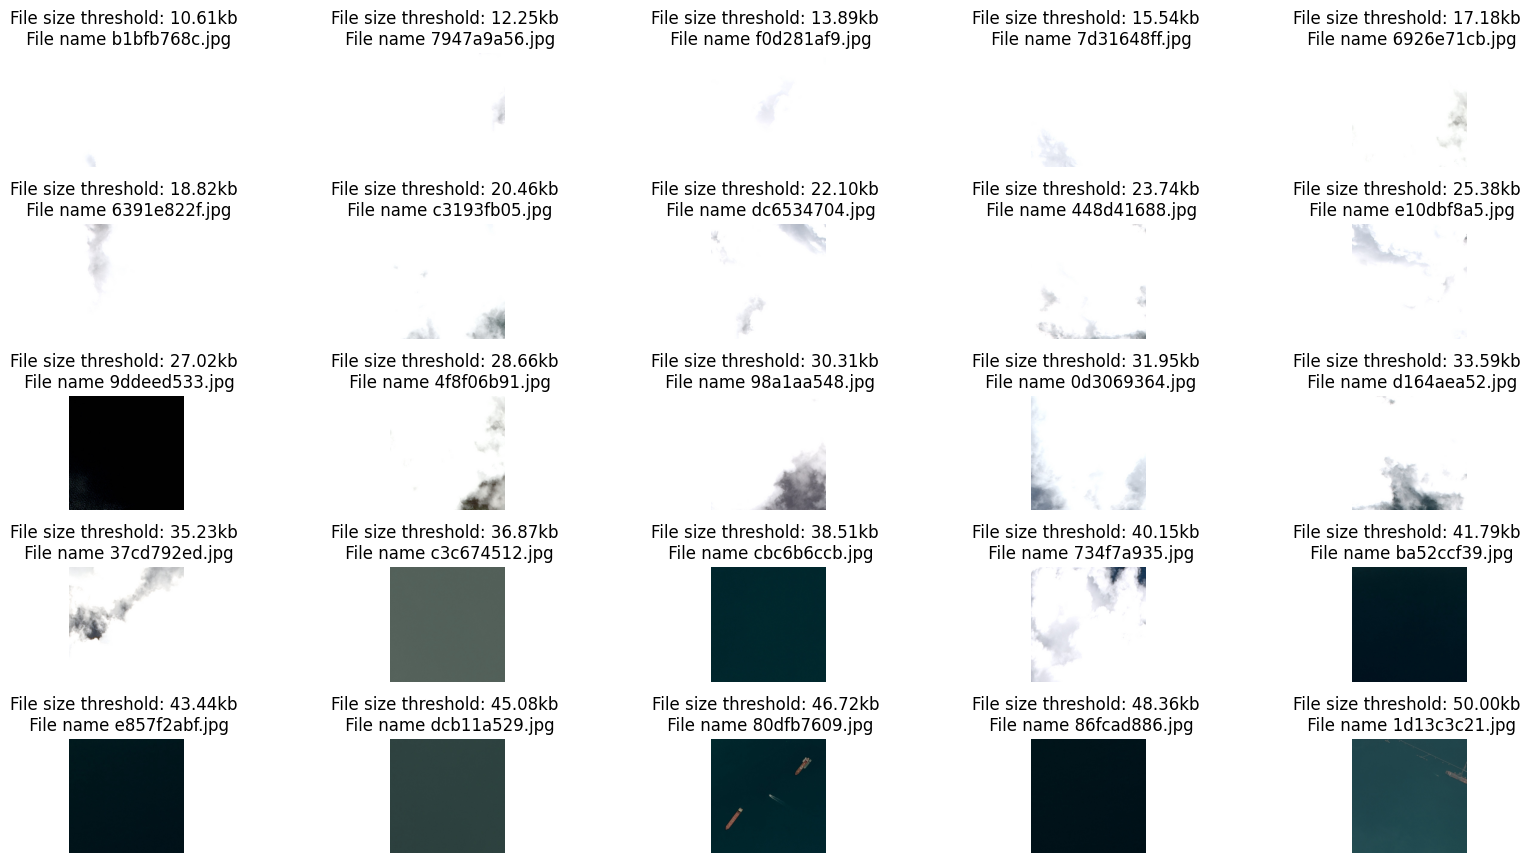

In [152]:
file_size_threshold = 50

ncols = 5
n = ncols ** 2
file_size_thresholds = np.linspace(files_data["file_size_kb"].min() + 1, 50, n)

fig, ax = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


for i, file_size_threshold in enumerate(file_size_thresholds):
    try:
        fname = files_data[files_data.file_size_kb < file_size_threshold].sort_values(by="file_size_kb", ascending=False).ImageId.iloc[0]
        image = imageio.imread(TRAIN_DIR / fname)
    except IndexError:
        image = np.random.randn(768, 768, 3) * 255

    ax[i//ncols, i%ncols].imshow(image)
    ax[i//ncols, i%ncols].set_title(f"File size threshold: {file_size_threshold:.2f}kb \n File name {fname}")
    ax[i//ncols, i%ncols].axis('off')

# image = imageio.imread(TRAIN_DIR / df[df.file_size_kb < file_size_threshold].sort_values(by="file_size_kb", ascending=False).ImageId.iloc[0])
# plt.imshow(image)
plt.show()

In [153]:
optimal_min_kb = 38 # discard all images with file size less than this

I will demonstrate a corrupted file. I suggest finding all such images using filtering based on HSV. We can search for it by the percentage of pixels of such a blue color or absolutely black. However, since such color does not change, we can find them even without HSV filtering. It's better to use blue since some cropped images appear later with boats. Similarly, we can filter images with clouds and without them. For this purpose, I have written the picker_d.py application using OpenCV, which will help find the necessary HSV parameters.

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\2795714712.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  corrupted_file = imageio.imread(TRAIN_DIR / "23fba4cea.jpg")


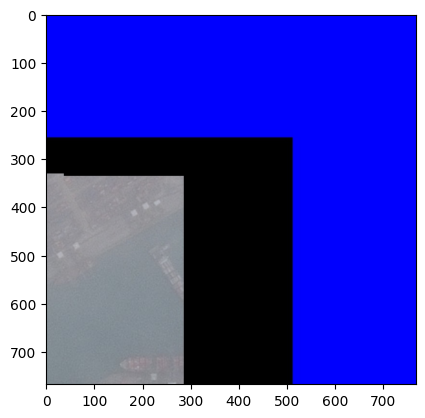

In [154]:
corrupted_file = imageio.imread(TRAIN_DIR / "23fba4cea.jpg")
plt.imshow(corrupted_file)
plt.show()

In [155]:
corrupted_file[0, 0]

array([  0,   0, 254], dtype=uint8)

In [156]:
# df["absolute_black"] = df.ImageId.map(lambda fname: np.sum(imageio.imread(TRAIN_DIR / fname) == 0) / (768 * 768 * 3))

In [157]:
HSV_BLUE_MIN = [115, 250, 250]
HSV_BLUE_MAX = [125, 255, 255]

HSV_BLACK_MIN = [0, 0, 0]
HSV_BLACK_MAX = [2, 2, 2]

HSV_WHITE_MIN = [0, 0, 119]
HSV_WHITE_MAX = [179, 7, 255]

In [158]:
def hsv_mask(image, hsv_min, hsv_max):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, np.array(hsv_min), np.array(hsv_max))
    return mask



In [159]:
files_data[files_data.ImageId == "2f6c0deaa.jpg"]

,ImageId,ships,file_size_kb
35679,2f6c0deaa.jpg,0,35.948242


In [160]:
files_data.shape

(192556, 3)

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\1530288261.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(DATA_DIR / "train_v2" / "8a3606c32.jpg")


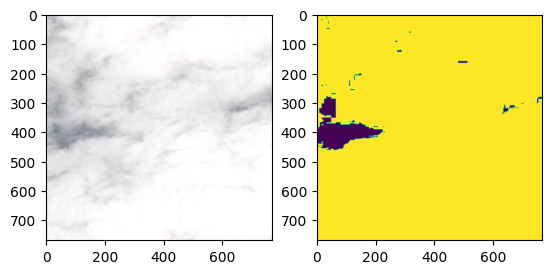

In [161]:
image = imageio.imread(DATA_DIR / "train_v2" / "8a3606c32.jpg")
mask = hsv_mask(image, hsv_min=HSV_WHITE_MIN, hsv_max=HSV_WHITE_MAX)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\2924911442.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / "abfc0019a.jpg")


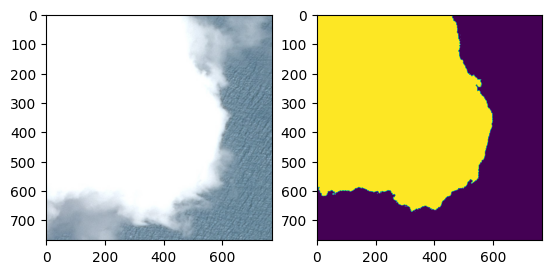

In [162]:
image = imageio.imread(TRAIN_DIR / "abfc0019a.jpg")
mask = hsv_mask(image, hsv_min=HSV_WHITE_MIN, hsv_max=HSV_WHITE_MAX)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\127215267.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / "23fba4cea.jpg")


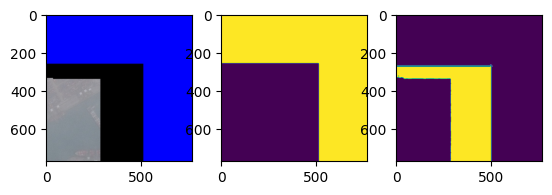

In [163]:
image = imageio.imread(TRAIN_DIR / "23fba4cea.jpg")
mask_blue = hsv_mask(image, hsv_min=HSV_BLUE_MIN, hsv_max=HSV_BLUE_MAX)
mask_black = hsv_mask(image, hsv_min=HSV_BLACK_MIN, hsv_max=HSV_BLACK_MAX)

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(mask_blue)
plt.subplot(1, 3, 3)
plt.imshow(mask_black)
plt.show()

In [164]:
# for OSError: image file is truncated
temp_func_errors = []

def temp_func(fname, hsv_min, hsv_max, name):
    global temp_func_errors

    try:
        image = imageio.imread(TRAIN_DIR / fname)
        mask = hsv_mask(image, hsv_min, hsv_max)
        mask = mask.astype(np.float32) / 255.
    except Exception as e:
        temp_func_errors.append((name, fname, e))
        return pd.NA

    return np.sum(mask) / (mask.shape[0] * mask.shape[1])

In [165]:

# If already runned once, load from csv
if (DATA_DIR / PROCESSED_CSV_NAME).exists():
    files_data = pd.read_csv(DATA_DIR / PROCESSED_CSV_NAME)

if "blue" not in files_data.columns:
    files_data["blue"] = files_data.ImageId.map(lambda fname: temp_func(fname, hsv_min=HSV_BLUE_MIN, hsv_max=HSV_BLUE_MAX, name="blue"))
    files_data.to_csv(DATA_DIR / PROCESSED_CSV_NAME, index=False)

if "white" not in files_data.columns:
    files_data["white"] = files_data.ImageId.map(lambda fname: temp_func(fname, hsv_min=HSV_WHITE_MIN, hsv_max=HSV_WHITE_MAX, name="white"))
    files_data.to_csv(DATA_DIR / PROCESSED_CSV_NAME, index=False)

if "black" not in files_data.columns:
    files_data["black"] = files_data.ImageId.map(lambda fname: temp_func(fname, hsv_min=HSV_BLACK_MIN, hsv_max=HSV_BLACK_MAX, name="black"))
    files_data.to_csv(DATA_DIR / PROCESSED_CSV_NAME, index=False)

# TODO: add gray color

print(temp_func_errors)

# [
# ('blue', '6384c3e78.jpg', OSError('image file is truncated (51 bytes not processed)')), 
# ('white', '6384c3e78.jpg', OSError('image file is truncated (51 bytes not processed)')), 
# ('black', '6384c3e78.jpg', OSError('image file is truncated (51 bytes not processed)'))
# ]

[]


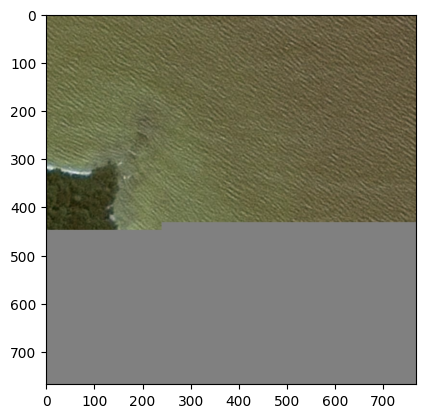

In [166]:
# image = image.imread(str(TRAIN_DIR / "6384c3e78.jpg")) # this function can't read this image
image = cv2.imread(str(TRAIN_DIR / "6384c3e78.jpg"))
plt.imshow(image)

Another option is not to discard such data but instead treat them as augmentations. Additionally, modeling such noise and adding it to the pipeline using the Albumentations library could be considered.

A third option is to mirror the images on black and blue areas. As we can see, black areas and blue areas are usually located next to each other. We then create a mask for black and blue areas, suppress false activations for black through Morphological Transform Opening, find the boundary, and mirror it.

Regarding removal:
- Currently, these are outliers that will only degrade the model's performance.

In favor of this option, I can say that:
- It may improve the robustness of the system if there is enough of this type of data.
- If such data is coming to us, we should find out how common it is (here we still need to run the algorithm below and look at the distribution). In that case, these may not be outliers but a standard condition, and we will need to process such cases.

As for images with clouds, they should be deleted as they do not add any value to the model. They can only be used when there are relatively few of them, say, 1/4 of the image. Cases where clouds cover almost the entire image can be processed programmatically - filter by HSV and look at the percentage of cloud coverage in the image. The algorithm could look like this:
- Run every nth frame for checking.
- If the percentage has risen to a threshold value, then in the next frames, there will likely be only clouds. Then, check not every nth frame but every frame until the percentage drops.
- When the percentage drops again, you can pass the image to the network, and reduce the algorithm's check frequency to every nth frame.

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\1658964335.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_before = imageio.imread(MEDIA_DIR / "027b381f0_before.jpg")
C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\1658964335.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_after = imageio.imread(MEDIA_DIR / "027b381f0_after.png")


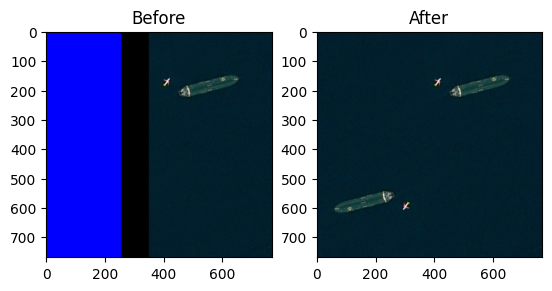

In [167]:
img_before = imageio.imread(MEDIA_DIR / "027b381f0_before.jpg")
img_after = imageio.imread(MEDIA_DIR / "027b381f0_after.png")

plt.subplot(1, 2, 1)
plt.imshow(img_before)
plt.title("Before")

plt.subplot(1, 2, 2)
plt.imshow(img_after)
plt.title("After")

plt.show()

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\663257793.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / fname)


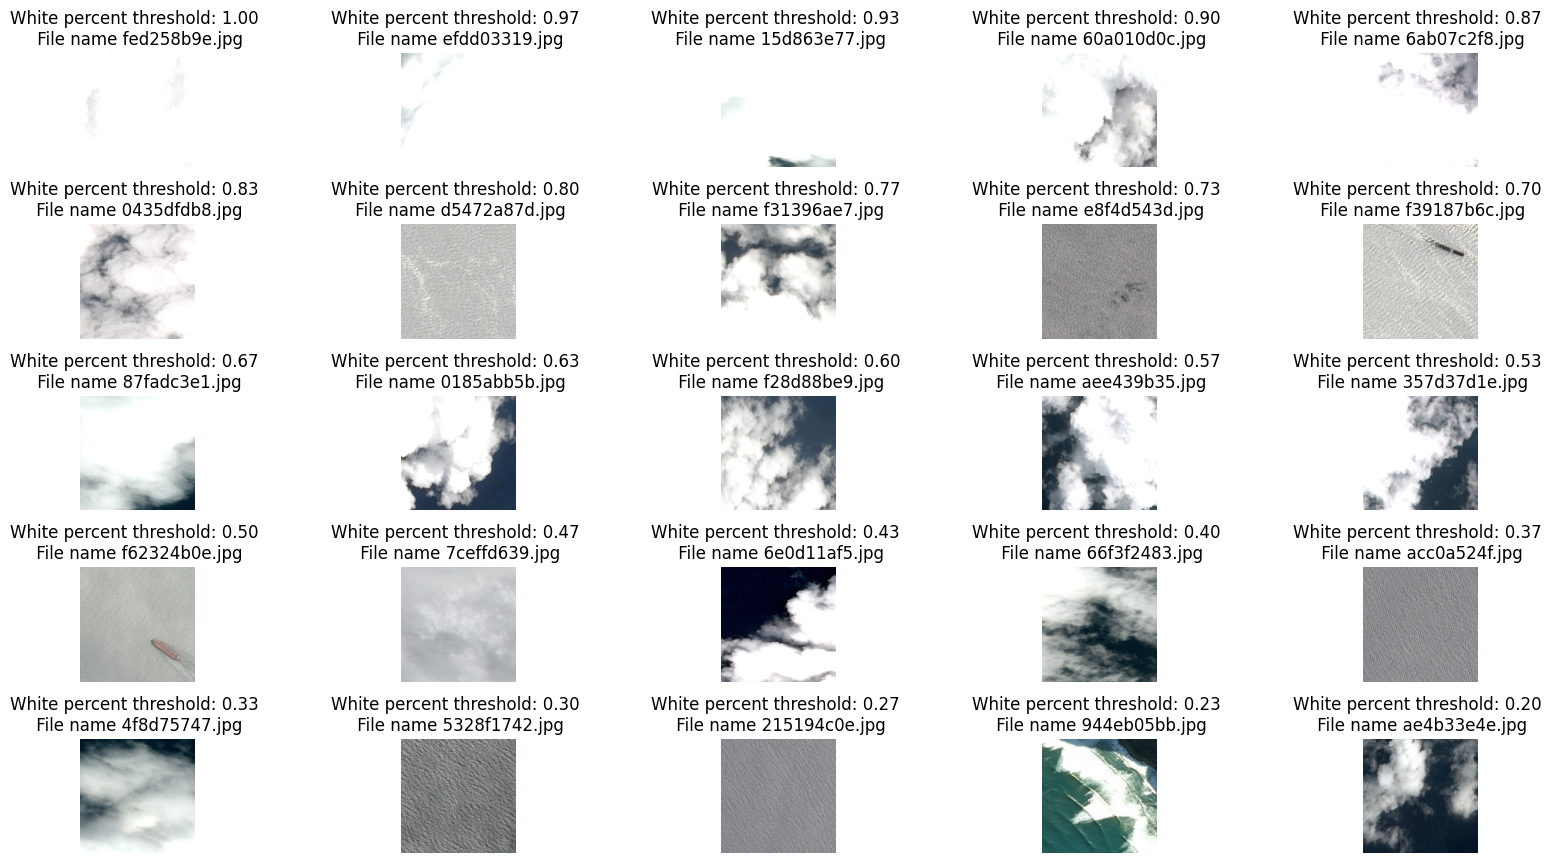

In [168]:
ncols = 5
n = ncols ** 2
white_thresholds = np.linspace(1, 0.2, n)

fig, ax = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


for i, white_threshold in enumerate(white_thresholds):
    try:
        fname = files_data[files_data.white < white_threshold].sort_values(by="white", ascending=False).ImageId.iloc[0]
        image = imageio.imread(TRAIN_DIR / fname)
    except IndexError:
        image = np.zeros((IMG_WIDTH, IMG_HEIGHT, N_CHANNELS))
        image[0] = 255

    ax[i//ncols, i%ncols].imshow(image)
    ax[i//ncols, i%ncols].set_title(f"White percent threshold: {white_threshold:.2f} \n File name {fname}")
    ax[i//ncols, i%ncols].axis('off')

plt.show()

The picture shows not only images with clouds but also those with illuminated sea. Thanks to the shades of gray, HSV also captures them. Knowing such examples, we could more accurately adjust the parameters for filtering using picker_d, which would exclude the shades of gray.

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\636987516.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / fname)


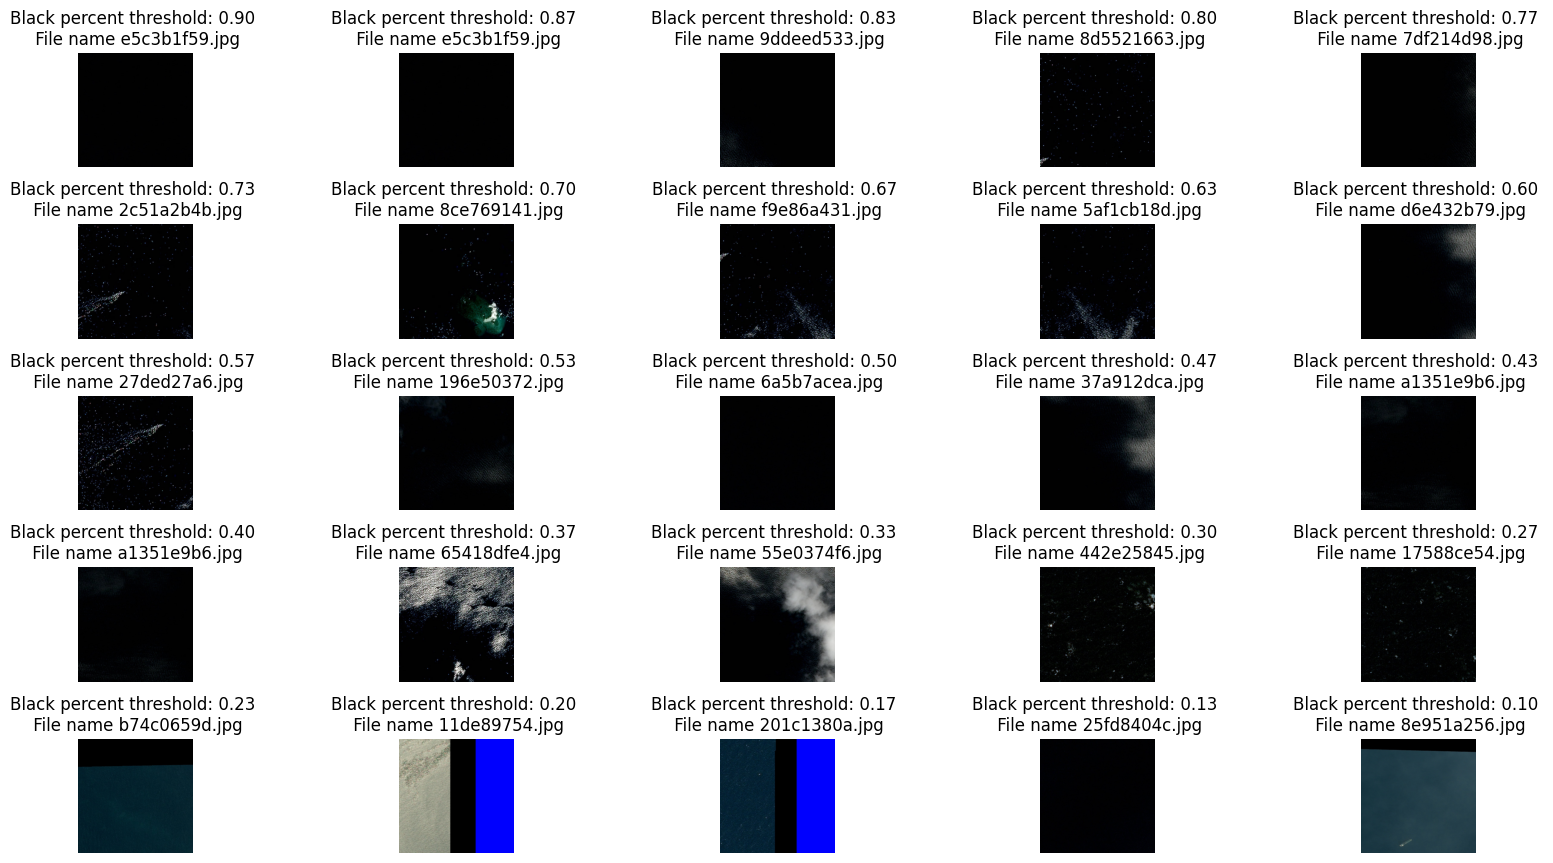

In [169]:
ncols = 5
n = ncols ** 2
black_thresholds = np.linspace(0.9, 0.1, n)

fig, ax = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


for i, black_threshold in enumerate(black_thresholds):
    try:
        fname = files_data[files_data.black > black_threshold].sort_values(by="black", ascending=True).ImageId.iloc[0]
        image = imageio.imread(TRAIN_DIR / fname)
    except IndexError:
        image = np.random.randn(IMG_WIDTH, IMG_HEIGHT, N_CHANNELS).astype(np.uint8) * 255


    ax[i//ncols, i%ncols].imshow(image)
    ax[i//ncols, i%ncols].set_title(f"Black percent threshold: {black_threshold:.2f} \n File name {fname}")
    ax[i//ncols, i%ncols].axis('off')

plt.show()

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\2081491094.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / fname)


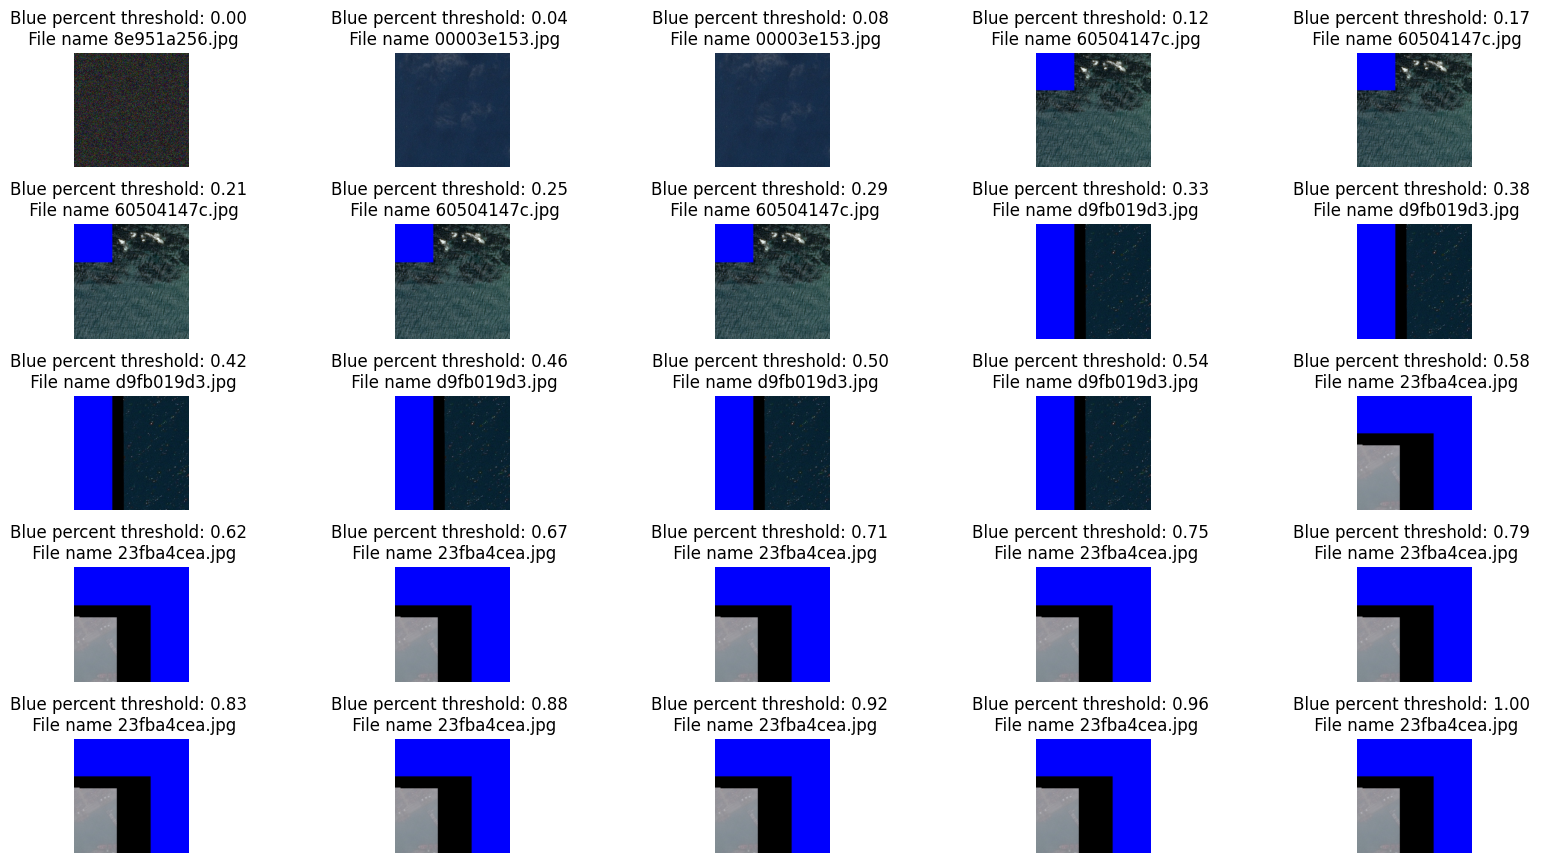

In [170]:
ncols = 5
n = ncols ** 2
blue_thresholds = np.linspace(0, 1, n)
delta = 0.05

fig, ax = plt.subplots(nrows=n//ncols, ncols=ncols, figsize=(20, 10))
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)


for i, blue_threshold in enumerate(blue_thresholds):
    try:
        # fname = files_data[(blue_threshold - delta < files_data.blue) & (files_data.blue < blue_threshold + delta)] \
        # .sort_values(by="blue", ascending=False) \
        # .ImageId.iloc[0]

        fname = files_data[files_data.blue < blue_threshold] \
        .sort_values(by="blue", ascending=False) \
        .ImageId.iloc[0]

        image = imageio.imread(TRAIN_DIR / fname)
    except IndexError:
        image = np.random.randn(IMG_WIDTH, IMG_HEIGHT, N_CHANNELS).astype(np.uint8) * 255


    ax[i//ncols, i%ncols].imshow(image)
    ax[i//ncols, i%ncols].set_title(f"Blue percent threshold: {blue_threshold:.2f} \n File name {fname}")
    ax[i//ncols, i%ncols].axis('off')

plt.show()

In [171]:
min_blue_threshold = 0.1

with_blue_shape = files_data[files_data.blue >= min_blue_threshold].shape
print(f"Total count of currupted with minimum level of blue={min_blue_threshold} files: {with_blue_shape[0]}")

Total count of currupted with minimum level of blue=0.1 files: 456


C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\2220641641.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(TRAIN_DIR / "03c807bd1.jpg")


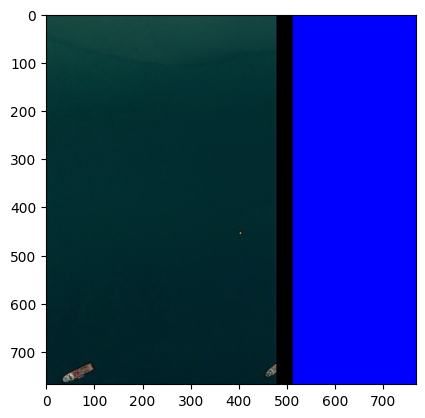

In [172]:
img = imageio.imread(TRAIN_DIR / "03c807bd1.jpg")
plt.imshow(img)   

Let's check if encoding and decoding RLE are done correctly.

True
True


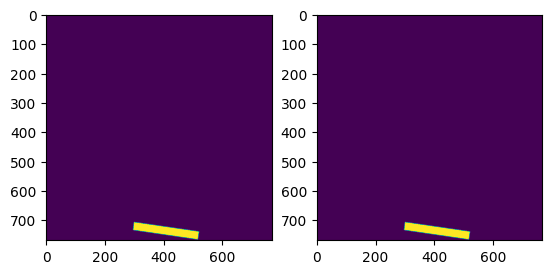

In [173]:
fname = "99d10330c.jpg"
rle = df[df.ImageId == fname].EncodedPixels.values[1]
mask = rle_decode(rle)
rle2 = rle_encode(mask)
mask2 = rle_decode(rle2)

print(rle == rle2)
print((1 - (mask - mask2)).all())

plt.subplot(1, 2, 1)
plt.imshow(mask)
plt.subplot(1, 2, 2)
plt.imshow(mask2)
plt.show()

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\3535781876.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(TRAIN_DIR / fname)


22f8ace63.jpg


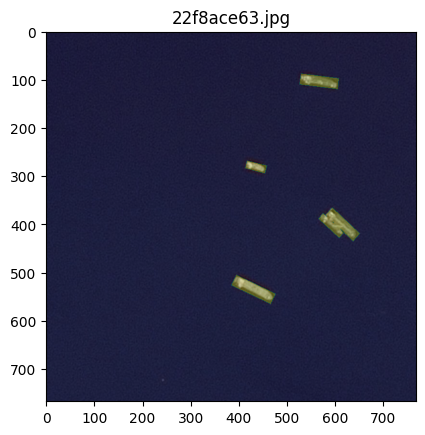

In [174]:
n = 5

fname = np.random.choice(files_data[files_data.ships == n].ImageId.values)
# fname = "99d10330c.jpg"
rles = df[df.ImageId == fname].EncodedPixels.values

img = imageio.imread(TRAIN_DIR / fname)
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
for rle in rles:
    mask_ = rle_decode(rle)
    mask = mask + mask_

mask = mask.clip(0, 1)
print(fname)
plt.imshow(img)
plt.imshow(mask, alpha=0.3)
plt.title(fname)
plt.show()

Let's combine the masks for the output into a single RLE (Run-Length Encoding) string.

In [175]:
def get_mask(image_id):
    rles = df[df.ImageId == image_id].EncodedPixels.values
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
    for rle in rles:
        mask += rle_decode(rle)
    
    mask = mask.clip(0, 1)
    return mask


In [176]:
if (DATA_DIR / "files_data.csv").exists():
    files_data = pd.read_csv(DATA_DIR / PROCESSED_CSV_NAME)

if "EncodedPixels" not in files_data.columns:
    print("Adding EncodedPixels column")
    files_data["EncodedPixels"] = pd.NA

    total_steps = files_data[files_data.ships > 0].shape[0]
    for index, (row_id, row) in enumerate(files_data[files_data.ships > 0].iterrows()):
        if (index + 1) % 2000 == 0:
            print(f"Processed {index + 1}/{total_steps} files")
        
        mask = get_mask(row.ImageId)
        rle = rle_encode(mask)
        files_data.loc[row_id, "EncodedPixels"] = rle
    
    files_data.to_csv(DATA_DIR / PROCESSED_CSV_NAME, index=False)


files_data.head(10)

,ImageId,ships,file_size_kb,blue,white,black,EncodedPixels
0,00003e153.jpg,0,128.944336,0.0,0.000000,0.0,NaN
1,0001124c7.jpg,0,76.059570,0.0,0.000000,0.0,NaN
2,000155de5.jpg,1,147.625977,0.0,0.000000,0.0,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,5,75.221680,0.0,0.000000,0.0,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
4,0001b1832.jpg,0,95.627930,0.0,0.000000,0.0,NaN
5,00021ddc3.jpg,9,242.910156,0.0,0.000083,0.0,74441 7 75207 9 75972 12 76738 14 77506 10 775...
6,0002756f7.jpg,2,287.620117,0.0,0.000000,0.0,248878 1 249645 4 250413 6 251180 9 251948 10 ...
7,0002d0f32.jpg,0,125.598633,0.0,0.079178,0.0,NaN
8,000303d4d.jpg,0,205.590820,0.0,0.000380,0.0,NaN
9,00031f145.jpg,1,232.898438,0.0,0.000387,0.0,340363 1 341129 4 341896 6 342663 7 343429 10 ...


C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\3196384777.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(TRAIN_DIR / fname)


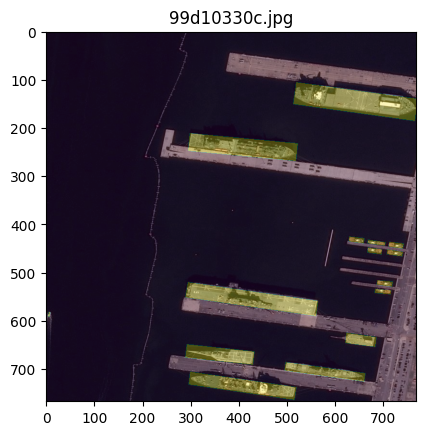

In [177]:
fname = "99d10330c.jpg"
rle = files_data[files_data.ImageId == fname].EncodedPixels.values[0]

img = imageio.imread(TRAIN_DIR / fname)
mask = rle_decode(rle)

plt.imshow(img)
plt.imshow(mask, alpha=0.3)
plt.title(fname)
plt.show()

Let's add another class to the mask - the area of small distance to neighboring ships. For implementation, I'm using Eroding/Dilating operations. This will help the model more accurately distinguish one ship from another, especially when they are close together.

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\1379111364.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(TRAIN_DIR / fname)


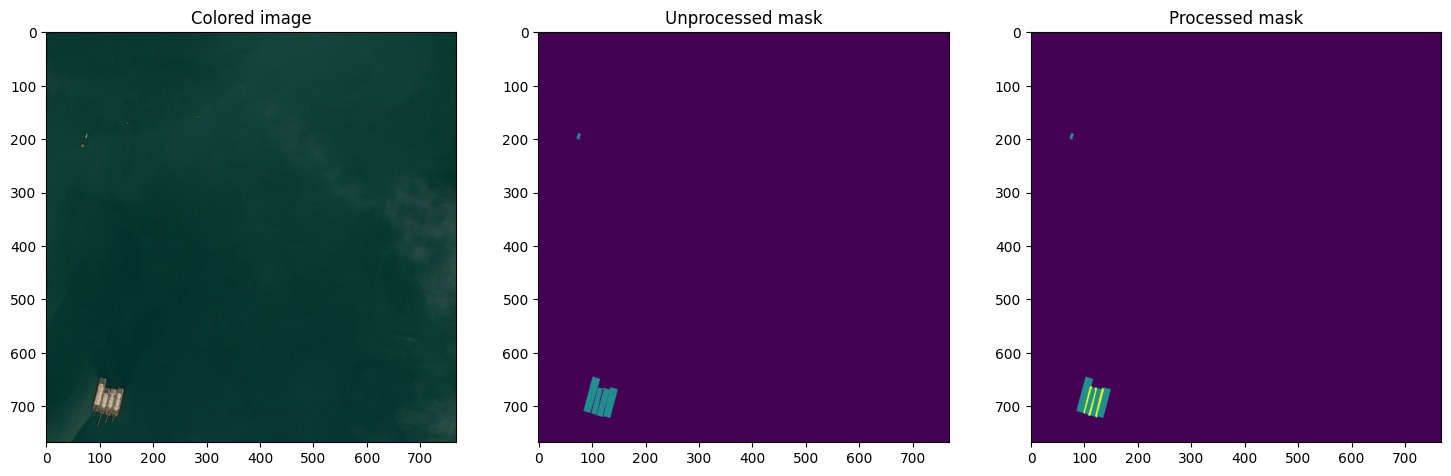

In [178]:
fname = "c8877230b.jpg"

rles = df[df.ImageId == fname].EncodedPixels.values

dilate_kernel = np.ones((5, 5),np.uint8)
erode_kernel = np.ones((2, 2),np.uint8)
iterations = 1

image = imageio.imread(TRAIN_DIR / fname)
low_distance_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
for rle in rles:
    rle_decoded_mask = rle_decode(rle)
    
    # dilating mask
    dilated_mask = cv2.dilate(rle_decoded_mask, dilate_kernel, iterations=iterations)
    low_distance_mask = low_distance_mask + dilated_mask

    mask = mask + rle_decoded_mask

low_distance_mask = (low_distance_mask > 1) * 2

pure_mask = mask.copy()
assert pure_mask.max() == 1

mask = mask + low_distance_mask
mask = mask.clip(0, 2)

mask_visual = mask.astype(np.float32) / 2 * 255
pure_mask_visual = pure_mask * 255 / 2

plt.figure(figsize=(18, 8))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Colored image")

plt.subplot(1, 3, 2)
plt.imshow(pure_mask_visual, vmin=0, vmax=255)
plt.title("Unprocessed mask")

plt.subplot(1, 3, 3)
plt.imshow(mask_visual, vmin=0, vmax=255)
plt.title("Processed mask")

plt.show()

In [179]:
files_data_filtered = files_data[(files_data.blue < min_blue_threshold) & (files_data.file_size_kb > optimal_min_kb)]

In [180]:
files_data_filtered.shape

(191802, 7)

Since the test task only requests **building a UNet**, we will limit ourselves to just a subset of the data. This will save a lot of time during experimentation. The training process is structured in such a way that if there is a need to train the model on all data later, the changes in the code will be minimal (read the README.md).

In [181]:
train_n = 10000
valid_n = 1000
test_n = 1000

n_files = files_data_filtered.shape[0]

train_ratio = 1 - train_n / n_files
valid_ratio = 1 - valid_n / (n_files - train_n)
test_ratio = 1 - test_n / (n_files - train_n - valid_n)

In [182]:
train_data, other_data = train_test_split(files_data_filtered, test_size=train_ratio, stratify=(files_data_filtered.ships > 0), random_state=42)
val_data, other_data = train_test_split(other_data, test_size=valid_ratio, stratify=(other_data.ships > 0), random_state=42)
test_data, other_data = train_test_split(other_data, test_size=test_ratio, stratify=(other_data.ships > 0), random_state=42)

train_fnames = train_data['ImageId'].values
val_fnames = val_data['ImageId'].values
test_fnames = test_data['ImageId'].values

In [183]:
len(train_fnames), len(val_fnames), len(test_fnames)

(10000, 1000, 1000)

In [184]:
train_data.to_csv(DATA_DIR / "train_data.csv", index=False)
val_data.to_csv(DATA_DIR / "val_data.csv", index=False)
test_data.to_csv(DATA_DIR / "test_data.csv", index=False)

We could build a DataGenerator that takes these .csv files, but for generality, it would be more appropriate to store the data in a file structure. The user won't have to encode their dataset in RLE. Although, we will also create a separate DataGenerator for csv files with RLE.

In [185]:
def make_subset(df, path_from, path_to):
    path_from = Path(path_from)
    path_to = Path(path_to)
    
    images_path = path_to / "images"
    masks_path = path_to / "masks"

    os.makedirs(images_path, exist_ok=True)
    os.makedirs(masks_path, exist_ok=True)

    for fname in df.ImageId.values:
        rle = df[df.ImageId == fname].EncodedPixels.values
        assert rle.shape[0] == 1, "More than one mask for image"
        rle = rle[0]

        fname_stem = Path(fname).stem

        if not isinstance(rle, str):
            mask = np.zeros((IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
        else:
            mask = rle_decode(rle)


        assert mask.max() <= 1, f"Mask values must be in [0, 1]. Fname: {fname}"
        shutil.copy(path_from / fname, images_path / fname)

        imageio.imwrite(masks_path / (fname_stem+".png"), mask)


In [186]:
make_subset(train_data, TRAIN_DIR, DATA_DIR / "train_subset")
make_subset(val_data, TRAIN_DIR, DATA_DIR / "val_subset")
make_subset(test_data, TRAIN_DIR, DATA_DIR / "test_subset")

In [187]:
# fname = "003d43308.jpg"

# mask = imageio.imread(DATA_DIR / "train_subset" / "masks" / fname)
# plt.imshow(mask)

# mask.max() # 2 => JPEG compression artifacts

In the `make_subset` function, there is an `assert mask.max() <= 1`, while the cell above states that there are pixels in the mask greater than 1. This means that jpg distorts the images. It is necessary to choose another format, for example, png.

C:\Users\jeka\AppData\Local\Temp\ipykernel_8480\3852501566.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(DATA_DIR / "train_subset" / "masks" / fname)


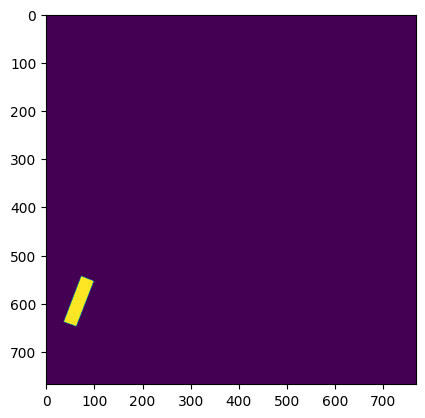

In [188]:
fname = "003d43308.png"

mask = imageio.imread(DATA_DIR / "train_subset" / "masks" / fname)
plt.imshow(mask)

In [189]:
mask.max() # 1

1

In the custom data generator, we will need to frequently read many images. Let's look at and compare the speed of reading in different libraries.

In [190]:
image_path = TRAIN_DIR / "378562135.jpg"
image_path.exists()

True

In [191]:
def cv_safe_read(path):
    img = cv2.imread(path)
    assert img is not None, f"Can't read image from path: {path}"
    return img

In [192]:
%%timeit 
cv2.imread(str(image_path))

8.19 ms ± 310 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [193]:
%%timeit 
cv_safe_read(str(image_path))

7.86 ms ± 86.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [194]:
%%timeit 
imageio.imread(str(image_path))

<magic-timeit>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


6.69 ms ± 87 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [195]:
%%timeit
Image.open(image_path)

163 µs ± 999 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [196]:
%%timeit
tf.keras.utils.load_img(image_path)

193 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
